# P02: 服装零售销售数据分析 - RFM客户价值分析

本Notebook演示如何使用RFM模型进行客户价值分析和客户细分。

**学习目标**:
- RFM模型原理与应用
- 客户价值评分方法
- 客户细分策略
- 精准营销建议

---

## 1. 环境准备

导入必要的库。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')

# 配置可视化样式
plt.style.use('seaborn-v0_8')
# 配置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12
sns.set_palette('Set2')

print("✅ 环境准备完成")
print(f"Pandas版本: {pd.__version__}")
print(f"NumPy版本: {np.__version__}")

✅ 环境准备完成
Pandas版本: 2.3.3
NumPy版本: 1.26.4


## 2. 数据加载

加载服装零售销售数据。

In [2]:
# 数据文件路径
data_path = '../../../../data/stage3/clothing_retail.csv'

# 加载数据
df = pd.read_csv(data_path, parse_dates=['order_date'])

print(f"数据加载完成: {len(df)} 行, {len(df.columns)} 列")
print(f"数据形状: {df.shape}")
print(f"\n时间范围: {df['order_date'].min().date()} 至 {df['order_date'].max().date()}")

数据加载完成: 2000 行, 21 列
数据形状: (2000, 21)

时间范围: 2023-01-01 至 2024-12-31


In [3]:
# 查看前几行
df.head()

,order_id,customer_id,order_date,product_id,product_name,category,brand,size,color,price,...,total_amount,discount,payment_method,shipping_method,region,customer_age,customer_gender,is_member,channel,status
0,EC2024101600000000,C000126,2024-10-16,P000058,H&M 裤子,裤子,ZARA,XXL,白色,106.50,...,319.50,0.18,支付宝,快递,华北,31,男,True,线下,已退货
1,EC2023081400000001,C000389,2023-08-14,P000041,ONLY 运动装,运动装,UR,M,蓝色,330.60,...,330.60,0.06,银行卡,快递,华北,42,男,False,小程序,已完成
2,EC2023021400000002,C000041,2023-02-14,P000142,无印良品 运动装,运动装,UR,XL,灰色,308.85,...,1235.40,0.21,支付宝,同城配送,华东,36,男,True,线上,已退货
3,EC2023101200000003,C000084,2023-10-12,P000095,UR 运动装,运动装,GAP,XXL,红色,349.63,...,1048.89,0.21,支付宝,同城配送,东北,28,男,True,APP,已退货
4,EC2023100400000004,C000118,2023-10-04,P000009,UR 外套,外套,ONLY,M,白色,746.69,...,746.69,0.06,银行卡,快递,东北,49,女,False,线下,已完成


In [4]:
# 数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         2000 non-null   object        
 1   customer_id      2000 non-null   object        
 2   order_date       2000 non-null   datetime64[ns]
 3   product_id       2000 non-null   object        
 4   product_name     2000 non-null   object        
 5   category         2000 non-null   object        
 6   brand            2000 non-null   object        
 7   size             2000 non-null   object        
 8   color            2000 non-null   object        
 9   price            2000 non-null   float64       
 10  quantity         2000 non-null   int64         
 11  total_amount     2000 non-null   float64       
 12  discount         2000 non-null   float64       
 13  payment_method   2000 non-null   object        
 14  shipping_method  2000 non-null   object 

## 3. RFM模型介绍

**RFM模型**是客户价值分析的经典方法，通过三个维度评估客户价值：

- **R (Recency)**: 最近一次购买距今天数 → 越小越好（最近购买的客户更活跃）
- **F (Frequency)**: 购买频率（订单数） → 越大越好（购买次数多表示忠诚度高）
- **M (Monetary)**: 购买金额（总消费） → 越大越好（消费金额高表示价值大）

### RFM模型应用场景

1. **客户细分**: 将客户分为不同群体，制定差异化策略
2. **精准营销**: 针对高价值客户提供VIP服务
3. **流失预警**: 识别R值上升的高价值客户
4. **营销ROI**: 优先投入资源在高价值客户上

---

## 4. 计算RFM指标

In [5]:
# 定义分析日期（通常为最后一个订单日期 + 1天）
analysis_date = df['order_date'].max() + pd.Timedelta(days=1)
print(f"分析日期: {analysis_date.date()}")

# 按客户聚合计算RFM
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (analysis_date - x.max()).days,  # R: 距离最后购买天数
    'order_id': 'count',                                      # F: 订单总数
    'total_amount': 'sum'                                     # M: 总消费金额
}).rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'total_amount': 'monetary'
})

print(f"\n客户总数: {len(rfm):,}")
print("\nRFM数据示例:")
rfm.head(10)

分析日期: 2025-01-01

客户总数: 493

RFM数据示例:


,recency,frequency,monetary
customer_id,,,
C000001,32,3,1214.00
C000002,457,3,1897.91
C000003,25,3,2459.46
C000004,12,5,4406.52
C000005,146,3,2497.32
C000006,142,4,3036.45
C000007,56,5,6376.41
C000008,157,2,348.00
C000009,143,6,5101.75


In [6]:
# RFM统计描述
print("RFM指标统计:")
rfm.describe()

RFM指标统计:


,recency,frequency,monetary
count,493.000000,493.000000,493.000000
mean,169.941176,4.056795,3333.632921
std,161.886549,1.983883,2254.033000
min,1.000000,1.000000,80.030000
25%,51.000000,3.000000,1496.790000
50%,111.000000,4.000000,2882.750000
75%,253.000000,5.000000,4724.650000
max,724.000000,10.000000,11633.990000


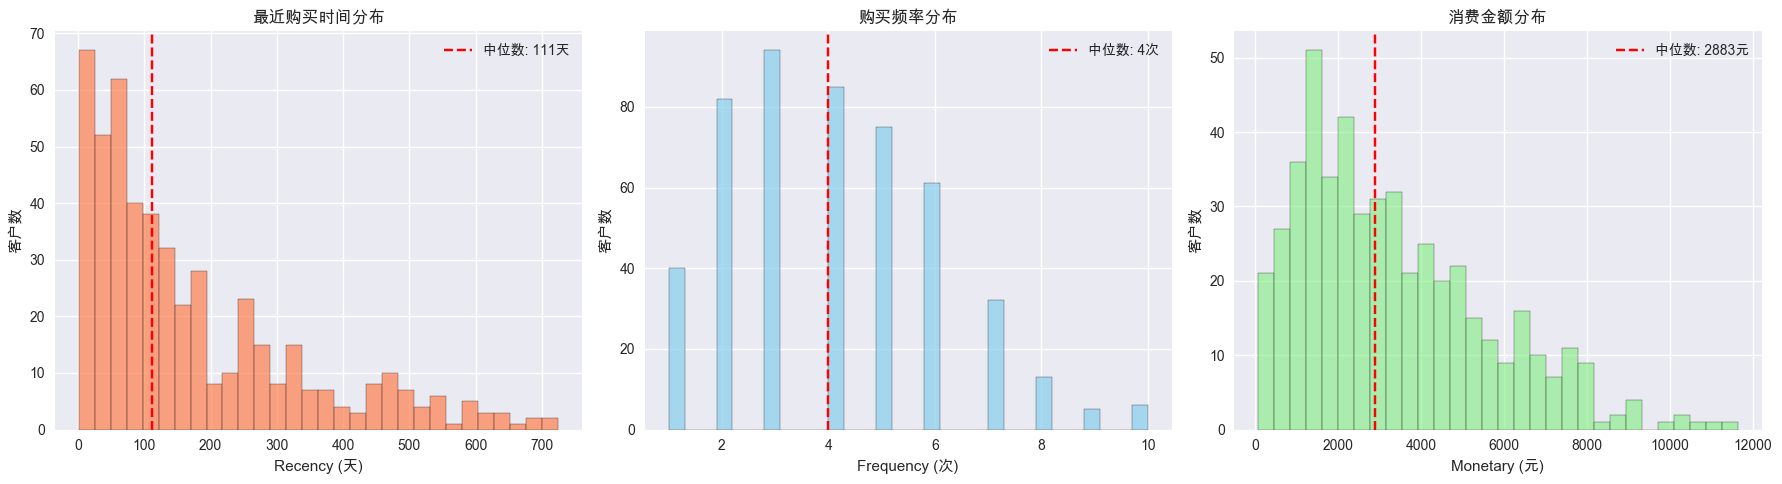

In [7]:
# RFM分布可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency分布
axes[0].hist(rfm['recency'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Recency (天)')
axes[0].set_ylabel('客户数')
axes[0].set_title('最近购买时间分布', fontweight='bold')
axes[0].axvline(rfm['recency'].median(), color='red', linestyle='--', label=f'中位数: {rfm["recency"].median():.0f}天')
axes[0].legend()

# Frequency分布
axes[1].hist(rfm['frequency'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Frequency (次)')
axes[1].set_ylabel('客户数')
axes[1].set_title('购买频率分布', fontweight='bold')
axes[1].axvline(rfm['frequency'].median(), color='red', linestyle='--', label=f'中位数: {rfm["frequency"].median():.0f}次')
axes[1].legend()

# Monetary分布
axes[2].hist(rfm['monetary'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Monetary (元)')
axes[2].set_ylabel('客户数')
axes[2].set_title('消费金额分布', fontweight='bold')
axes[2].axvline(rfm['monetary'].median(), color='red', linestyle='--', label=f'中位数: {rfm["monetary"].median():.0f}元')
axes[2].legend()

plt.tight_layout()
plt.show()

## 5. RFM评分

将RFM三个维度分别打分（1-5分），使用**分位数法**：
- R: 越小越好 → 5分（最近）到1分（很久）
- F: 越大越好 → 5分（高频）到1分（低频）
- M: 越大越好 → 5分（高消费）到1分（低消费）

In [8]:
# 计算RFM评分（使用分位数法）
# R评分：R越小越好，所以分数倒序
rfm['R_score'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# F评分：F越大越好
rfm['F_score'] = pd.qcut(rfm['frequency'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# M评分：M越大越好
rfm['M_score'] = pd.qcut(rfm['monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# 计算RFM总分（可以用于排序）
rfm['RFM_score'] = rfm['R_score'].astype(int) * 100 + \
                   rfm['F_score'].astype(int) * 10 + \
                   rfm['M_score'].astype(int)

print("RFM评分完成！")
print("\n评分示例（按RFM总分降序）:")
rfm.sort_values('RFM_score', ascending=False).head(10)

RFM评分完成！

评分示例（按RFM总分降序）:


,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
customer_id,,,,,,,
C000500,15,7,8631.33,5,5,5,555
C000053,8,10,10527.40,5,5,5,555
C000394,33,8,10947.47,5,5,5,555
C000383,21,8,6462.13,5,5,5,555
C000035,38,10,10144.30,5,5,5,555
C000340,8,8,7439.80,5,5,5,555
C000052,12,9,5676.94,5,5,5,555
C000471,35,10,6332.78,5,5,5,555
C000059,23,8,5563.30,5,5,5,555


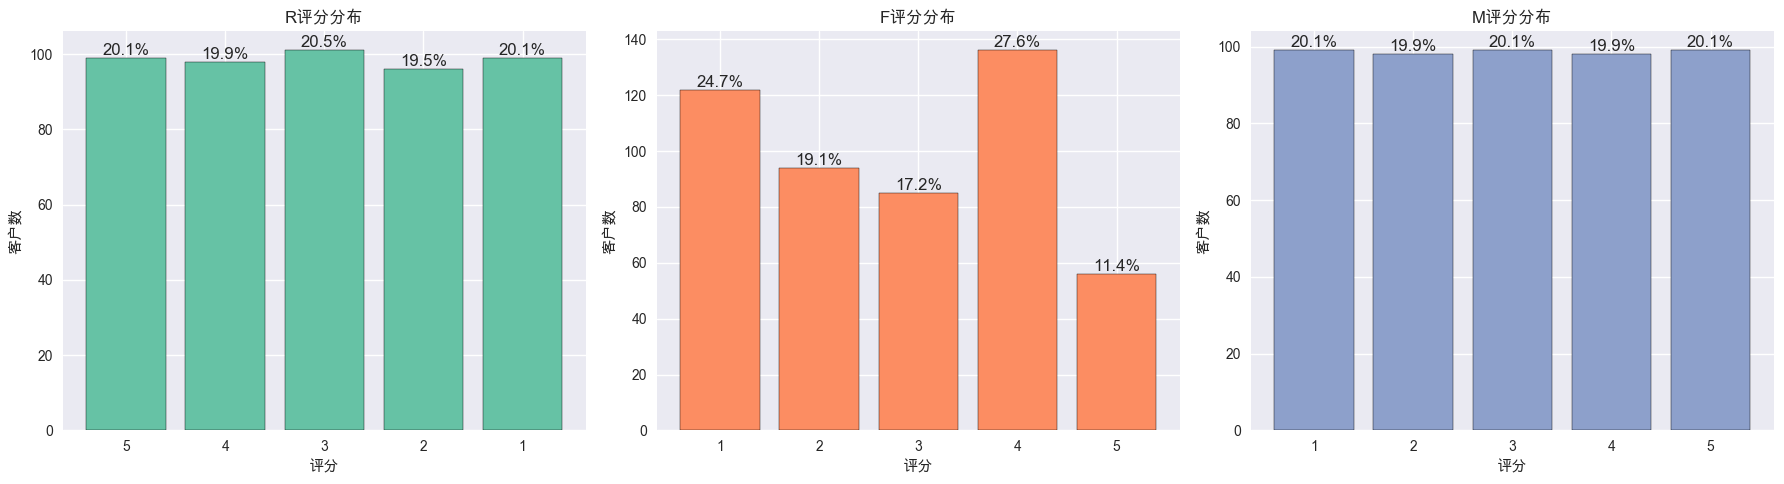

In [9]:
# RFM评分分布
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['R_score', 'F_score', 'M_score']):
    score_counts = rfm[col].value_counts().sort_index()
    axes[i].bar(score_counts.index.astype(str), score_counts.values, color=sns.color_palette('Set2')[i], edgecolor='black')
    axes[i].set_xlabel('评分')
    axes[i].set_ylabel('客户数')
    axes[i].set_title(f'{col[0]}评分分布', fontweight='bold')
    
    # 添加百分比标签
    for j, (idx, val) in enumerate(score_counts.items()):
        pct = val / len(rfm) * 100
        axes[i].text(j, val, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. 客户细分

基于RFM评分，将客户分为不同群体。

In [10]:
def segment_customers(row):
    """
    客户细分规则
    
    根据R/F/M评分组合，将客户分为7个群体
    """
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    
    # 重要价值客户：RFM都高（最近购买、高频、高消费）
    if r >= 4 and f >= 4 and m >= 4:
        return '重要价值客户'
    
    # 重要保持客户：R高，F或M一般（最近购买但频率或金额一般）
    elif r >= 4 and (f >= 2 or m >= 2):
        return '重要保持客户'
    
    # 重要挽留客户：R低，F和M高（曾经的高价值客户，但最近没购买）
    elif r <= 2 and f >= 4 and m >= 4:
        return '重要挽留客户'
    
    # 一般发展客户：F或M高，R一般（有潜力的客户）
    elif (f >= 3 or m >= 3) and r >= 2:
        return '一般发展客户'
    
    # 一般维持客户：RFM都中等
    elif r >= 2 and f >= 2 and m >= 2:
        return '一般维持客户'
    
    # 一般挽留客户：R低，F或M一般
    elif r <= 2 and (f >= 2 or m >= 2):
        return '一般挽留客户'
    
    # 潜在客户：RFM都低（新客户或低价值客户）
    else:
        return '潜在客户'

# 应用细分规则
rfm['customer_segment'] = rfm.apply(segment_customers, axis=1)

print("客户细分完成！")
print("\n各群体客户数:")
segment_counts = rfm['customer_segment'].value_counts()
for segment, count in segment_counts.items():
    pct = count / len(rfm) * 100
    print(f"  {segment:12s}: {count:4d} ({pct:5.1f}%)")

客户细分完成！

各群体客户数:
  一般发展客户      :  117 ( 23.7%)
  重要保持客户      :  107 ( 21.7%)
  潜在客户        :   80 ( 16.2%)
  重要价值客户      :   77 ( 15.6%)
  一般挽留客户      :   63 ( 12.8%)
  重要挽留客户      :   29 (  5.9%)
  一般维持客户      :   20 (  4.1%)


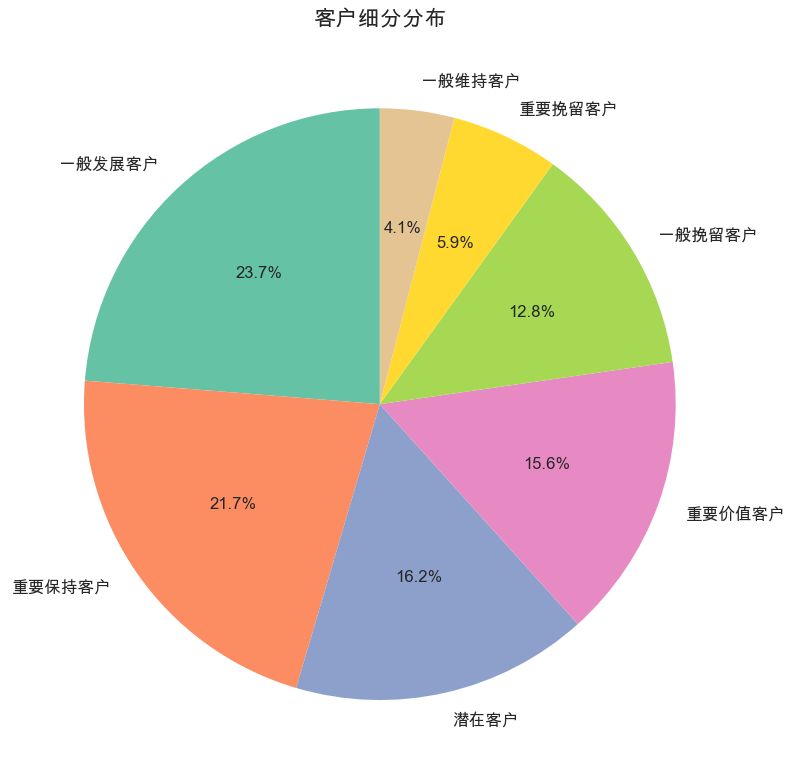

In [11]:
# 客户细分分布饼图
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set2', n_colors=len(segment_counts))
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('客户细分分布', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 各客户群体特征分析

In [12]:
# 各群体RFM均值
segment_rfm = rfm.groupby('customer_segment')[['recency', 'frequency', 'monetary']].mean()
segment_rfm = segment_rfm.round(2)

print("各客户群体RFM特征:")
print(segment_rfm)

各客户群体RFM特征:
                  recency  frequency  monetary
customer_segment                              
一般发展客户             145.56       4.58   4273.14
一般挽留客户             401.70       2.79   2347.36
一般维持客户             184.70       3.00   1831.48
潜在客户               289.80       1.68    838.89
重要价值客户              37.06       6.58   5766.71
重要保持客户              39.40       3.88   2631.24
重要挽留客户             258.45       5.93   5735.16


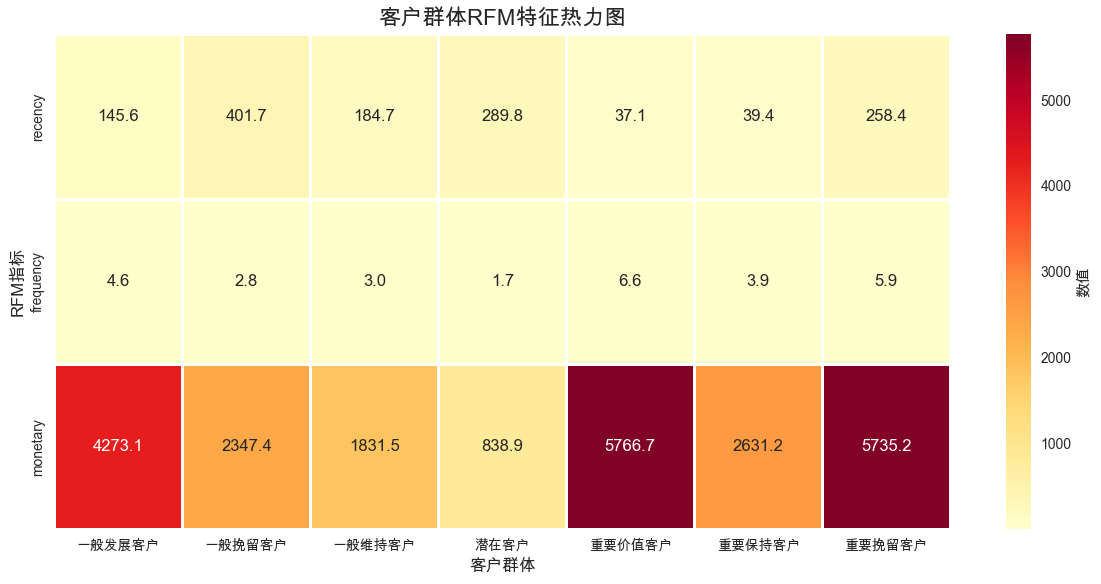

In [13]:
# RFM特征热力图
plt.figure(figsize=(12, 6))
sns.heatmap(segment_rfm.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=1, cbar_kws={'label': '数值'})
plt.title('客户群体RFM特征热力图', fontsize=16, fontweight='bold')
plt.xlabel('客户群体', fontsize=12)
plt.ylabel('RFM指标', fontsize=12)
plt.tight_layout()
plt.show()

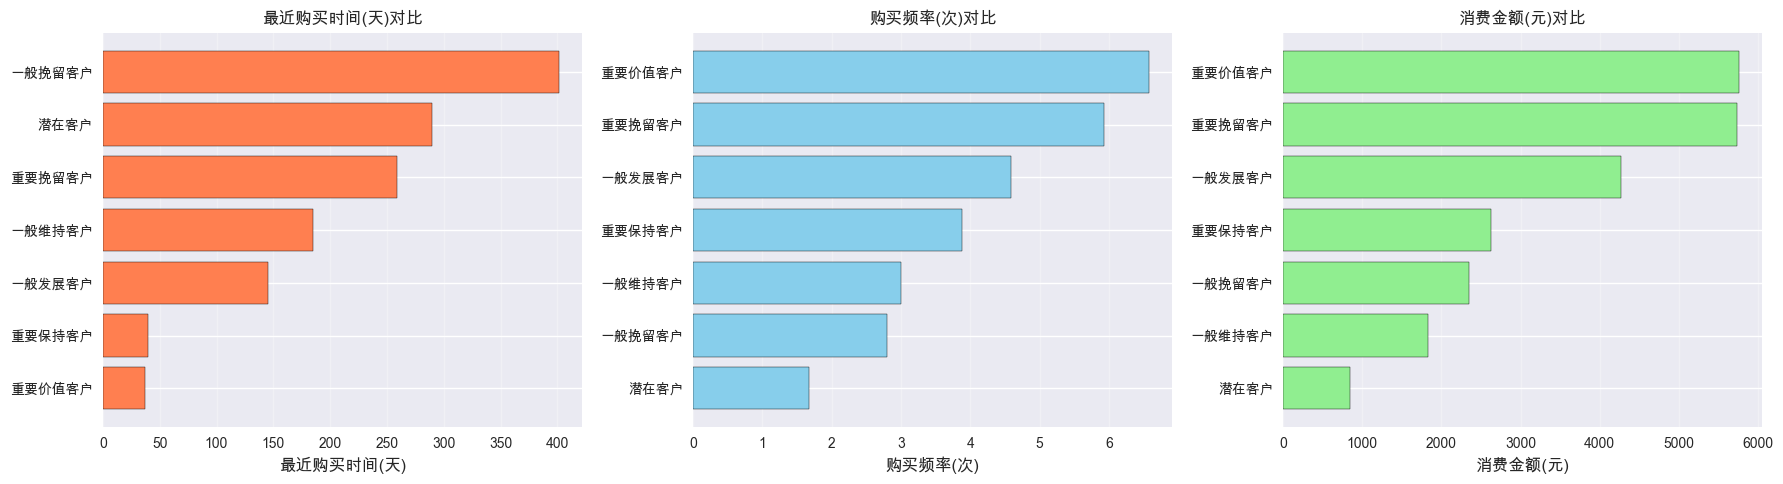

In [14]:
# 各群体RFM对比柱状图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['recency', 'frequency', 'monetary']
titles = ['最近购买时间(天)', '购买频率(次)', '消费金额(元)']
colors_list = ['coral', 'skyblue', 'lightgreen']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors_list)):
    segment_metric = rfm.groupby('customer_segment')[metric].mean().sort_values()
    axes[i].barh(range(len(segment_metric)), segment_metric.values, color=color, edgecolor='black')
    axes[i].set_yticks(range(len(segment_metric)))
    axes[i].set_yticklabels(segment_metric.index)
    axes[i].set_xlabel(title, fontsize=12)
    axes[i].set_title(f'{title}对比', fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 业务洞察与营销建议

In [15]:
# 生成各群体详细分析
print("="*80)
print("客户群体分析报告")
print("="*80)

for segment in rfm['customer_segment'].unique():
    segment_data = rfm[rfm['customer_segment'] == segment]
    count = len(segment_data)
    pct = count / len(rfm) * 100
    
    avg_r = segment_data['recency'].mean()
    avg_f = segment_data['frequency'].mean()
    avg_m = segment_data['monetary'].mean()
    
    print(f"\n【{segment}】")
    print(f"  客户数: {count} ({pct:.1f}%)")
    print(f"  平均最近购买: {avg_r:.0f} 天前")
    print(f"  平均购买频率: {avg_f:.1f} 次")
    print(f"  平均消费金额: {avg_m:.2f} 元")
    
    # 营销建议
    if segment == '重要价值客户':
        print("  📌 营销策略: VIP专属服务、新品优先体验、生日礼遇、积分翻倍")
    elif segment == '重要挽留客户':
        print("  📌 营销策略: 唤回活动、限时大额优惠券、专属客服、流失原因调研")
    elif segment == '重要保持客户':
        print("  📌 营销策略: 会员升级激励、推荐奖励、搭配促销、定期关怀")
    elif segment == '一般发展客户':
        print("  📌 营销策略: 会员权益推广、积分兑换、社交分享活动、品类扩展")
    elif segment == '一般维持客户':
        print("  📌 营销策略: 定期促销、满减活动、新品推荐、内容营销")
    elif segment == '一般挽留客户':
        print("  📌 营销策略: 回归优惠、产品反馈调研、个性化推荐、补贴活动")
    else:  # 潜在客户
        print("  📌 营销策略: 首单优惠、试用装、低门槛活动、内容种草")

print("\n" + "="*80)

客户群体分析报告

【重要保持客户】
  客户数: 107 (21.7%)
  平均最近购买: 39 天前
  平均购买频率: 3.9 次
  平均消费金额: 2631.24 元
  📌 营销策略: 会员升级激励、推荐奖励、搭配促销、定期关怀

【一般挽留客户】
  客户数: 63 (12.8%)
  平均最近购买: 402 天前
  平均购买频率: 2.8 次
  平均消费金额: 2347.36 元
  📌 营销策略: 回归优惠、产品反馈调研、个性化推荐、补贴活动

【重要价值客户】
  客户数: 77 (15.6%)
  平均最近购买: 37 天前
  平均购买频率: 6.6 次
  平均消费金额: 5766.71 元
  📌 营销策略: VIP专属服务、新品优先体验、生日礼遇、积分翻倍

【一般发展客户】
  客户数: 117 (23.7%)
  平均最近购买: 146 天前
  平均购买频率: 4.6 次
  平均消费金额: 4273.14 元
  📌 营销策略: 会员权益推广、积分兑换、社交分享活动、品类扩展

【潜在客户】
  客户数: 80 (16.2%)
  平均最近购买: 290 天前
  平均购买频率: 1.7 次
  平均消费金额: 838.89 元
  📌 营销策略: 首单优惠、试用装、低门槛活动、内容种草

【重要挽留客户】
  客户数: 29 (5.9%)
  平均最近购买: 258 天前
  平均购买频率: 5.9 次
  平均消费金额: 5735.16 元
  📌 营销策略: 唤回活动、限时大额优惠券、专属客服、流失原因调研

【一般维持客户】
  客户数: 20 (4.1%)
  平均最近购买: 185 天前
  平均购买频率: 3.0 次
  平均消费金额: 1831.48 元
  📌 营销策略: 定期促销、满减活动、新品推荐、内容营销



## 9. 总结

### 关键发现

通过RFM模型分析，我们实现了：

1. **客户价值量化**: 将客户按照R/F/M三个维度打分（1-5分）
2. **精准客户细分**: 识别出7个不同特征的客户群体
3. **差异化策略**: 针对每个群体制定专属营销方案

### 业务建议

1. **资源优先级**: 80/20法则，80%资源投入到20%的高价值客户
2. **流失预警**: 重点监控"重要挽留客户"，及时干预
3. **客户成长**: 将"一般发展客户"培育成"重要价值客户"
4. **动态更新**: 每月/每季度更新RFM评分，追踪客户变化

### 延伸思考

1. **RFM+**: 可以加入更多维度，如客户年龄、地域、偏好品类
2. **CLV预测**: 基于RFM预测客户生命周期价值（Customer Lifetime Value）
3. **自动化**: 将RFM分析集成到CRM系统，实时更新
4. **A/B测试**: 针对不同细分群体测试营销策略效果

---

## 10. 数据导出（可选）

In [16]:
from pathlib import Path

# 创建输出目录
output_dir = Path('../outputs/processed_data')
output_dir.mkdir(parents=True, exist_ok=True)

# 保存RFM分析结果
rfm_output = rfm.copy()
rfm_output['R_score'] = rfm_output['R_score'].astype(int)
rfm_output['F_score'] = rfm_output['F_score'].astype(int)
rfm_output['M_score'] = rfm_output['M_score'].astype(int)

csv_path = output_dir / 'rfm_analysis.csv'
rfm_output.to_csv(csv_path, encoding='utf-8')
print(f"✅ RFM分析结果已保存: {csv_path}")

# 保存客户细分结果
segment_summary = rfm.groupby('customer_segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2)

segment_summary['customer_count'] = rfm['customer_segment'].value_counts()
segment_summary['percentage'] = (segment_summary['customer_count'] / len(rfm) * 100).round(2)

summary_path = output_dir / 'customer_segments_summary.csv'
segment_summary.to_csv(summary_path, encoding='utf-8')
print(f"✅ 客户细分汇总已保存: {summary_path}")

✅ RFM分析结果已保存: ../outputs/processed_data/rfm_analysis.csv
✅ 客户细分汇总已保存: ../outputs/processed_data/customer_segments_summary.csv


---

## 💡 扩展练习

完成基础分析后，可以尝试：

1. **动态RFM**: 对比不同时间段的RFM变化，分析客户迁移
2. **RFM+聚类**: 使用K-means对RFM数据聚类，与规则分群对比
3. **关联分析**: 分析不同细分客户的商品偏好
4. **预测模型**: 基于RFM特征预测客户未来消费
5. **可视化仪表盘**: 使用Plotly创建交互式RFM仪表盘

---

**项目完成时间**: 预计2-4小时  
**难度等级**: ⭐⭐ 入门  
**前置知识**: Pandas分组聚合、数据可视化

**下一个项目**: [P03 - 银行营销分类](../../p03-finance/)